Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/240111_robust_tests/FAT/'
save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/240111_robust_tests/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 169.26it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:17<00:00,  2.34it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [4]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 30
setting = 'FedAvg_adv'
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 15


save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'


for num_user in num_users:
    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    aggregator, clients, args_ = set_args(setting, 40)

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FAT150)
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    aggregator.update_clients()
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()
    
    for c in aggregator.clients:
        c.unlearning_flag = True
    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator, model_FAT)

    prev_model = copy.deepcopy(model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
     # Assign proportion and attack params
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%5 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 172.54it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


round 0 Test acc:  0.8125 ( 0.0 ) adv acc:  0.38750001788139343 ( 0.0 )


/home/ubuntu/fedatk_unl_tj/learners/learner.py:189: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 5 Test acc:  0.5875000357627869 ( 0.0 ) adv acc:  0.17499999701976776 ( 0.0 )
round 10 Test acc:  0.625 ( 0.0 ) adv acc:  0.125 ( 0.0 )
round 15 Test acc:  0.625 ( 0.0 ) adv acc:  0.1875 ( 0.0 )
round 20 Test acc:  0.612500011920929 ( 0.0 ) adv acc:  0.16250000894069672 ( 0.0 )
round 25 Test acc:  0.6500000357627869 ( 0.0 ) adv acc:  0.1875 ( 0.0 )
round 30 Test acc:  0.6625000238418579 ( 0.0 ) adv acc:  0.16250000894069672 ( 0.0 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 238.16it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


round 0 Test acc:  0.7791666785875956 ( 0.02568505641187949 ) adv acc:  0.4083333412806193 ( 0.031180485657121493 )
round 5 Test acc:  0.5041666726271311 ( 0.031180483002122648 ) adv acc:  0.054166668405135475 ( 0.015590239841683623 )
round 10 Test acc:  0.6416666706403097 ( 0.04823266268665965 ) adv acc:  0.09999999900658925 ( 0.017677670232111163 )
round 15 Test acc:  0.6416666905085245 ( 0.03864006806629781 ) adv acc:  0.08749999975164731 ( 0.03061862148062106 )
round 20 Test acc:  0.6500000158945719 ( 0.03679899551102374 ) adv acc:  0.09583333383003871 ( 0.031180479683367245 )
round 25 Test acc:  0.6541666785875956 ( 0.015590245483573495 ) adv acc:  0.10416666666666667 ( 0.015590239509808416 )
round 30 Test acc:  0.675000011920929 ( 0.010206197528198842 ) adv acc:  0.09166666616996129 ( 0.025685058426280327 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 232.11it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


round 0 Test acc:  0.7674999952316284 ( 0.023184047267113435 ) adv acc:  0.33999999761581423 ( 0.04568917125040484 )
round 5 Test acc:  0.700000011920929 ( 0.06661455984068006 ) adv acc:  0.07750000227242708 ( 0.04430011419953345 )
round 10 Test acc:  0.7125000119209289 ( 0.06519202130914718 ) adv acc:  0.08250000178813935 ( 0.03221024709438592 )
round 15 Test acc:  0.7300000071525574 ( 0.07356969233625668 ) adv acc:  0.08250000104308128 ( 0.023184047347454457 )
round 20 Test acc:  0.7775000095367431 ( 0.061947570109187125 ) adv acc:  0.10500000268220902 ( 0.04227883714147613 )
round 25 Test acc:  0.7325000166893005 ( 0.09861542029808196 ) adv acc:  0.08500000089406967 ( 0.0215058125786502 )
round 30 Test acc:  0.7475000143051147 ( 0.05884301158099558 ) adv acc:  0.08000000044703484 ( 0.028062430453904604 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 244.80it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


round 0 Test acc:  0.787500011920929 ( 0.04069705295484746 ) adv acc:  0.3512500077486038 ( 0.06310952694499937 )
round 5 Test acc:  0.6800000131130218 ( 0.06304759600675076 ) adv acc:  0.09375000074505806 ( 0.03633610394234067 )
round 10 Test acc:  0.7050000190734863 ( 0.08717798769070162 ) adv acc:  0.09374999981373548 ( 0.04155192502709483 )
round 15 Test acc:  0.7087500154972076 ( 0.05943746285282157 ) adv acc:  0.10250000078231096 ( 0.047037219996576334 )
round 20 Test acc:  0.7150000095367431 ( 0.07862093419326167 ) adv acc:  0.10750000104308129 ( 0.035881751211938755 )
round 25 Test acc:  0.6987500131130219 ( 0.07467639315790132 ) adv acc:  0.1025000018067658 ( 0.04430011306428989 )
round 30 Test acc:  0.7037500023841858 ( 0.0776711827586675 ) adv acc:  0.09875000081956387 ( 0.04200074473063862 )


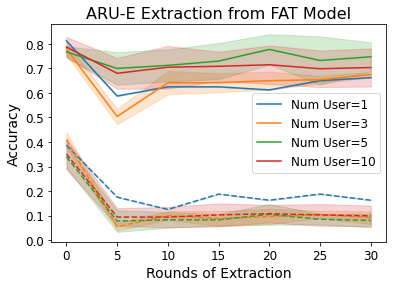

In [5]:

# Initialize a new figure
plt.figure(figsize=(6, 4))

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 35, 5)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('ARU-E Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()